In [2]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("HungerDataAnalysis").getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/23 09:19:54 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [11]:
wasting_df = spark.read.csv("Wasting.csv", header=True, inferSchema=True)
expenditure_df = spark.read.csv("Expenditure.csv", header=True, inferSchema=True)
malnutrition_df = spark.read.csv("Malnutrition.csv", header=True, inferSchema=True)

from pyspark.sql.types import FloatType

def convert_double_to_float(df):
    for column, dtype in df.dtypes:
        if dtype == 'double':
            df = df.withColumn(column, df[column].cast(FloatType()))
    return df

wasting_df = convert_double_to_float(wasting_df)
expenditure_df = convert_double_to_float(expenditure_df)
malnutrition_df = convert_double_to_float(malnutrition_df)

wasting_df.printSchema()
expenditure_df.printSchema()
malnutrition_df.printSchema()


root
 |-- Area Code (FAO): integer (nullable = true)
 |-- Area: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- GDP_Per_Capita_PPP: float (nullable = true)
 |-- Children_Under_5_Wasting_Percent: float (nullable = true)

root
 |-- Area Code (FAO): integer (nullable = true)
 |-- Area: string (nullable = true)
 |-- Year_Code: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Agriculture_CG: float (nullable = true)
 |-- Total_Expenditure_CG: float (nullable = true)

root
 |-- Area Code (FAO): integer (nullable = true)
 |-- Area: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Incidence of malnutrition: float (nullable = true)



# Filling the null# 

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, col, when

spark = SparkSession.builder.appName("HungerDataAnalysis").getOrCreate()

expenditure_df = spark.read.csv("Expenditure.csv", header=True, inferSchema=True)
malnutrition_df = spark.read.csv("Malnutrition.csv", header=True, inferSchema=True)
wasting_df = spark.read.csv("Wasting.csv", header=True, inferSchema=True)

def fill_na_with_region_year_mean(df, group_by_cols):
    for col_name in df.columns:
        if col_name not in group_by_cols:
            mean_df = df.groupBy(group_by_cols).agg(mean(col_name).alias('mean_' + col_name))
            df = df.join(mean_df, on=group_by_cols, how='left')
            df = df.withColumn(col_name, when(df[col_name].isNull(), col('mean_' + col_name)).otherwise(df[col_name]))
            df = df.drop('mean_' + col_name)
    return df

# fill null
expenditure_df = fill_na_with_region_year_mean(expenditure_df, ['Area', 'Year'])
malnutrition_df = fill_na_with_region_year_mean(malnutrition_df, ['Area', 'Year'])
wasting_df = fill_na_with_region_year_mean(wasting_df, ['Area', 'Year'])

# show after filling
expenditure_df.show()
malnutrition_df.show()
wasting_df.show()

+-----------+----+---------------+---------+--------------+--------------------+
|       Area|Year|Area Code (FAO)|Year_Code|Agriculture_CG|Total_Expenditure_CG|
+-----------+----+---------------+---------+--------------+--------------------+
|    Armenia|2017|            1.0|      1.0|         76.01|             3117.36|
|    Armenia|2018|            1.0|      2.0|         53.74|             2996.11|
|    Armenia|2019|            1.0|      3.0|         63.14|             3391.52|
|    Armenia|2020|            1.0|      4.0|         61.32|             3874.46|
|    Armenia|2021|            1.0|      5.0|         87.18|             3978.61|
|    Armenia|2022|            1.0|      6.0|        134.42|             5147.58|
|Afghanistan|2017|            2.0|      7.0|          null|             9026.27|
|Afghanistan|2018|            2.0|      8.0|          null|             5611.66|
|Afghanistan|2019|            2.0|      9.0|          null|             5459.32|
|Afghanistan|2020|          

In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, col, when, isnull, sum as spark_sum

# Create SparkSession
spark = SparkSession.builder.appName("HungerDataAnalysis").getOrCreate()

#Load the dataset
expenditure_df = spark.read.csv("Expenditure.csv", header=True, inferSchema=True)
malnutrition_df = spark.read.csv("Malnutrition.csv", header=True, inferSchema=True)
wasting_df = spark.read.csv("Wasting.csv", header=True, inferSchema=True)

# Check null value function
def check_nulls(df):
     return df.select([spark_sum(isnull(col(c)).cast("int")).alias(c) for c in df.columns])

#Display null values
print("Expenditure DataFrame null value situation:")
check_nulls(expenditure_df).show()

print("Malnutrition DataFrame null value situation:")
check_nulls(malnutrition_df).show()

print("Wasting DataFrame null value situation:")
check_nulls(wasting_df).show()

# Fill in the null value function
def fill_na_with_area_mean(df, group_by_col):
     for col_name in df.columns:
         if col_name != group_by_col:
             mean_df = df.groupBy(group_by_col).agg(mean(col_name).alias('mean_' + col_name))
             df = df.join(mean_df, on=group_by_col, how='left')
             df = df.withColumn(col_name, when(df[col_name].isNull(), col('mean_' + col_name)).otherwise(df[col_name]))
             df = df.drop('mean_' + col_name)
     return df

# Fill in empty values based on Area
expenditure_df = fill_na_with_area_mean(expenditure_df, 'Area')
malnutrition_df = fill_na_with_area_mean(malnutrition_df, 'Area')
wasting_df = fill_na_with_area_mean(wasting_df, 'Area')

# Display the null values after filling in the null values
print("Expenditure DataFrame filled with null values:")
check_nulls(expenditure_df).show()

print("Malnutrition DataFrame filled with null values: ")
check_nulls(malnutrition_df).show()

print("Wasting DataFrame filled with null values: ")
check_nulls(wasting_df).show()

Expenditure DataFrame null value situation:
+---------------+----+---------+----+--------------+--------------------+
|Area Code (FAO)|Area|Year_Code|Year|Agriculture_CG|Total_Expenditure_CG|
+---------------+----+---------+----+--------------+--------------------+
|              0|   0|        0|   0|          1077|                 511|
+---------------+----+---------+----+--------------+--------------------+

Malnutrition DataFrame null value situation:
+---------------+----+----+-------------------------+
|Area Code (FAO)|Area|Year|Incidence of malnutrition|
+---------------+----+----+-------------------------+
|              0|   0|   0|                      917|
+---------------+----+----+-------------------------+

Wasting DataFrame null value situation:
+---------------+----+----+------------------+--------------------------------+
|Area Code (FAO)|Area|Year|GDP_Per_Capita_PPP|Children_Under_5_Wasting_Percent|
+---------------+----+----+------------------+-----------------------

In [6]:
expenditure_df = expenditure_df.na.drop()
malnutrition_df = malnutrition_df.na.drop()
wasting_df = wasting_df.na.drop()

# Display the null values after filling in the null values
print("Expenditure DataFrame filled with null values:")
check_nulls(expenditure_df).show()

print("Malnutrition DataFrame filled with null values: ")
check_nulls(malnutrition_df).show()

print("Wasting DataFrame filled with null values: ")
check_nulls(wasting_df).show()

Expenditure DataFrame filled with null values:
+----+---------------+---------+----+--------------+--------------------+
|Area|Area Code (FAO)|Year_Code|Year|Agriculture_CG|Total_Expenditure_CG|
+----+---------------+---------+----+--------------+--------------------+
|   0|              0|        0|   0|             0|                   0|
+----+---------------+---------+----+--------------+--------------------+

Malnutrition DataFrame filled with null values: 
+----+---------------+----+-------------------------+
|Area|Area Code (FAO)|Year|Incidence of malnutrition|
+----+---------------+----+-------------------------+
|   0|              0|   0|                        0|
+----+---------------+----+-------------------------+

Wasting DataFrame filled with null values: 
+----+---------------+----+------------------+--------------------------------+
|Area|Area Code (FAO)|Year|GDP_Per_Capita_PPP|Children_Under_5_Wasting_Percent|
+----+---------------+----+------------------+------------

# Remove Outliers, Extreme Values

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lit
from pyspark.sql.window import Window
import pyspark.sql.functions as F

# Create SparkSession
spark = SparkSession.builder.appName("HungerDataAnalysis").getOrCreate()


# Detect and replace extreme value functions
def replace_outliers_iqr(df, col_name):
     q1 = df.approxQuantile(col_name, [0.25], 0.01)[0]
     q3 = df.approxQuantile(col_name, [0.75], 0.01)[0]
     iqr = q3 - q1
     lower_bound = q1 - 1.5 * iqr
     upper_bound = q3 + 1.5 * iqr

     # Find non-extreme data points
     non_outliers_df = df.filter((col(col_name) >= lower_bound) & (col(col_name) <= upper_bound))

     # Window function sorts by year and region to obtain the previous and next non-extreme points
     window_spec = Window.orderBy("Year").rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

     # Get the previous and next non-extreme data points
     prev_non_outlier = F.last(col(col_name), ignorenulls=True).over(window_spec)
     next_non_outlier = F.first(col(col_name), ignorenulls=True).over(window_spec)

     # Replace extreme values
     df = df.withColumn(
         col_name,
         when((col(col_name) < lower_bound) | (col(col_name) > upper_bound),
              when(col(col_name) < lower_bound, next_non_outlier).otherwise(prev_non_outlier)
             ).otherwise(col(col_name))
     )
     return df

#Replace the extreme values in the specified column
expenditure_df = replace_outliers_iqr(expenditure_df, 'Agriculture_CG')
expenditure_df = replace_outliers_iqr(expenditure_df, 'Total_Expenditure_CG')
malnutrition_df = replace_outliers_iqr(malnutrition_df, 'Incidence of malnutrition')
wasting_df = replace_outliers_iqr(wasting_df, 'Children_Under_5_Wasting_Percent')

# Display the processed DataFrame
expenditure_df.show()
malnutrition_df.show()
wasting_df.show()


24/05/23 09:21:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 09:21:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 09:21:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 09:21:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 09:21:20 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 09:21:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 0

+-----------------+---------------+---------+------+------------------+--------------------+
|             Area|Area Code (FAO)|Year_Code|  Year|    Agriculture_CG|Total_Expenditure_CG|
+-----------------+---------------+---------+------+------------------+--------------------+
|             Chad|           39.0|    205.0|2017.0|             33.27|              1121.4|
|         Paraguay|          169.0|    937.0|2017.0|            150.08|             6462.26|
|          Senegal|          195.0|   1093.0|2017.0|            106.12|             4830.19|
|       Cabo Verde|           35.0|    181.0|2017.0|             10.77|              560.47|
|           Sweden|          210.0|   1177.0|2017.0|            571.77|             3846.78|
|Republic of Korea|          117.0|    637.0|2017.0|             46.63|             3846.78|
|           Guyana|           91.0|    493.0|2017.0|             96.38|             1162.32|
|            Tonga|          219.0|   1231.0|2017.0|              5.32

24/05/23 09:21:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 09:21:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 09:21:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 09:21:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 09:21:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 09:21:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 0

+--------------------+---------------+------+-------------------------+
|                Area|Area Code (FAO)|  Year|Incidence of malnutrition|
+--------------------+---------------+------+-------------------------+
|                Chad|           39.0|2017.0|                     26.0|
|            Paraguay|          169.0|2017.0|                      2.8|
|               Yemen|          249.0|2017.0|                    43.64|
|             Senegal|          195.0|2017.0|                      7.3|
|          Cabo Verde|           35.0|2017.0|                     20.9|
|            Kiribati|           83.0|2017.0|                     10.9|
|              Guyana|           91.0|2017.0|                      3.3|
|         Philippines|          171.0|2017.0|                      6.4|
|            Djibouti|           72.0|2017.0|                     19.9|
|            Malaysia|          131.0|2017.0|                      5.2|
|                Fiji|           66.0|2017.0|                   

24/05/23 09:21:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 09:21:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 09:21:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 09:21:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 09:21:25 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 09:21:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 0

+-----------------+---------------+------+------------------+--------------------------------+
|             Area|Area Code (FAO)|  Year|GDP_Per_Capita_PPP|Children_Under_5_Wasting_Percent|
+-----------------+---------------+------+------------------+--------------------------------+
|    Côte d'Ivoire|          107.0|2017.0|            4750.9|                             8.4|
|             Chad|           39.0|2017.0|            1579.8|                            10.6|
|         Paraguay|          169.0|2017.0|           13604.2|                             1.0|
|          Senegal|          195.0|2017.0|            3259.2|                             9.0|
|         Kiribati|           83.0|2017.0|            1962.3|                             3.5|
|Republic of Korea|          117.0|2017.0|           40957.4|                             0.9|
|           Guyana|           91.0|2017.0|           12193.6|                             6.5|
|         Djibouti|           72.0|2017.0|        

24/05/23 09:21:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 09:21:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 09:21:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 09:21:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 09:21:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 09:21:37 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 0

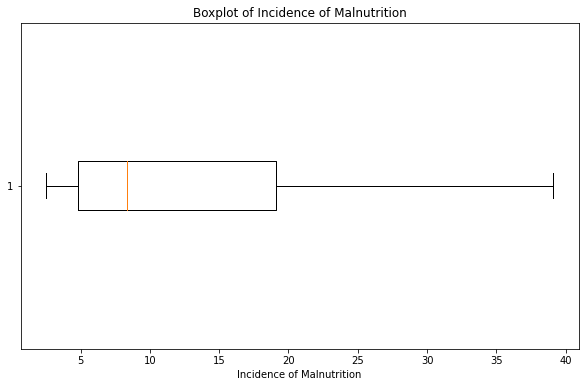

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert PySpark DataFrame to Pandas DataFrame
malnutrition_df_pd = malnutrition_df.toPandas()

# Draw a boxplot of malnutrition prevalence
plt.figure(figsize=(10, 6))
plt.boxplot(malnutrition_df_pd['Incidence of malnutrition'].dropna(), vert=False)
plt.title('Boxplot of Incidence of Malnutrition')
plt.xlabel('Incidence of Malnutrition')
plt.show()

# Remove Irrelevant Values

In [9]:
import pandas as pd

expenditure_df = pd.read_csv('Expenditure.csv')

# Delete the year_code column
expenditure_df = expenditure_df.drop(columns=['Year_Code'])

print(expenditure_df.head())

   Area Code (FAO)     Area  Year  Agriculture_CG  Total_Expenditure_CG
0                1  Armenia  2017           76.01               3117.36
1                1  Armenia  2018           53.74               2996.11
2                1  Armenia  2019           63.14               3391.52
3                1  Armenia  2020           61.32               3874.46
4                1  Armenia  2021           87.18               3978.61


# Formatting Data

In [12]:
# Change all float type data to display two decimal places
def format_float_columns(df):
     float_cols = [col_name for col_name, dtype in df.dtypes if dtype == 'Float']
     for col_name in float_cols:
         df = df.withColumn(col_name, format_number(col(col_name), 2))
     return df

expenditure_df = format_float_columns(expenditure_df)
malnutrition_df = format_float_columns(malnutrition_df)
wasting_df = format_float_columns(wasting_df)

# Data Construction

In [40]:
# compute the mean gdp by area code
from pyspark.sql.functions import avg
mean_gdp_by_country = wasting_df.groupBy('Area Code (FAO)').agg(avg('GDP_Per_Capita_PPP')\.alias('Mean GDP'))
mean_gdp_by_country.show()

+---------------+------------------+
|Area Code (FAO)|          Mean GDP|
+---------------+------------------+
|            148|          11972.54|
|            137|22009.159999999996|
|            251|3322.8599999999997|
|             53|            3127.7|
|            255|          50850.28|
|            133|2160.5600000000004|
|            108|          25646.22|
|            155|           2953.28|
|            193|4009.3599999999997|
|            211| 70044.45999999999|
|            101|          11514.18|
|            115|           4257.08|
|            126|36573.020000000004|
|             81| 5219.879999999999|
|             28|           4535.68|
|            183|          29101.82|
|            210|52418.520000000004|
|             26|60595.659999999996|
|             27|          22763.14|
|             44|14282.740000000002|
+---------------+------------------+
only showing top 20 rows



In [45]:
# convert into incomelevels
income_category = mean_gdp_by_country.withColumn("IncomeLevel",
    when(col("`Mean GDP`") <= 1135, "Low income")
    .when((col("`Mean GDP`") > 1136) & (col("`Mean GDP`") <= 4465), "Lower middle income")
    .when((col("`Mean GDP`") > 4466) & (col("`Mean GDP`") <= 13845), "Upper middle income")
    .otherwise("High income")
)
income_category.show()

+---------------+------------------+-------------------+
|Area Code (FAO)|          Mean GDP|        IncomeLevel|
+---------------+------------------+-------------------+
|            148|          11972.54|Upper middle income|
|            137|22009.159999999996|        High income|
|            251|3322.8599999999997|Lower middle income|
|             53|            3127.7|Lower middle income|
|            255|          50850.28|        High income|
|            133|2160.5600000000004|Lower middle income|
|            108|          25646.22|        High income|
|            155|           2953.28|Lower middle income|
|            193|4009.3599999999997|Lower middle income|
|            211| 70044.45999999999|        High income|
|            101|          11514.18|Upper middle income|
|            115|           4257.08|Lower middle income|
|            126|36573.020000000004|        High income|
|             81| 5219.879999999999|Upper middle income|
|             28|           453

# Various Data Integration

In [43]:
combined_df = expenditure_df.join(malnutrition_df, on=['Area Code (FAO)', 'Area', 'Year'], how='outer')
combined_df = combined_df.join(wasting_df, on=['Area Code (FAO)', 'Area', 'Year'], how='outer')

#Display the merged data set
combined_df.show(truncate=False)

+---------------+-----------+----+---------+--------------+--------------------+-------------------------+------------------+--------------------------------+
|Area Code (FAO)|Area       |Year|Year_Code|Agriculture_CG|Total_Expenditure_CG|Incidence of malnutrition|GDP_Per_Capita_PPP|Children_Under_5_Wasting_Percent|
+---------------+-----------+----+---------+--------------+--------------------+-------------------------+------------------+--------------------------------+
|1              |Armenia    |2017|1        |76.01         |3117.36             |null                     |12509.6           |null                            |
|1              |Armenia    |2018|2        |53.74         |2996.11             |null                     |13231.4           |null                            |
|1              |Armenia    |2019|3        |63.14         |3391.52             |null                     |14317.6           |null                            |
|1              |Armenia    |2020|4        |61

# Data format conversion

In [47]:
from pyspark.sql.functions import col, when

fin_df= income_category.withColumn("IncomeLevel", 
                               when(col("IncomeLevel") == "Lower middle income", 1)
                               .when(col("IncomeLevel") == "Upper middle income", 2)
                               .when(col("IncomeLevel") == "High income", 3)
                               .when(col("IncomeLevel") == "Low income", 0)
                               .otherwise(col("IncomeLevel")))
fin_df.show()

+---------------+------------------+-----------+
|Area Code (FAO)|          Mean GDP|IncomeLevel|
+---------------+------------------+-----------+
|            148|          11972.54|          2|
|            137|22009.159999999996|          3|
|            251|3322.8599999999997|          1|
|             53|            3127.7|          1|
|            255|          50850.28|          3|
|            133|2160.5600000000004|          1|
|            108|          25646.22|          3|
|            155|           2953.28|          1|
|            193|4009.3599999999997|          1|
|            211| 70044.45999999999|          3|
|            101|          11514.18|          2|
|            115|           4257.08|          1|
|            126|36573.020000000004|          3|
|             81| 5219.879999999999|          2|
|             28|           4535.68|          2|
|            183|          29101.82|          3|
|            210|52418.520000000004|          3|
|             26|605